# Lecture 15: Density Estimation  

#### This notebook was developed by [Zeljko Ivezic](http://faculty.washington.edu/ivezic/) for the 2021 data science class at the University of Sao Paulo and it is available from [github](https://github.com/ivezic/SaoPaulo2021/blob/main/notebooks/Lecture15.ipynb).

Note: this notebook contains code developed by Z. Ivezic, M. Juric, A. Connolly, B. Sippocz, Jake VanderPlas, G. Richards and many others.

<a id='toc'></a>

## This notebook includes:


[Searching for Structure in 1-D Point Data](#basics) 

[Gaussian Mixture Models](#GMM)

[Extreme Deconvolution](#XD) 

[Bonus: Density Estimation for the SDSS "Great Wall"](#SDSS)

In [38]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats

from sklearn.neighbors import KernelDensity

from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist

The code below ensures the fonts in plots are rendered LaTex.  
This function adjusts matplotlib settings for a uniform feel in the textbook.  
Note that with usetex=True, fonts are rendered with LaTeX.  This may
result in an error if LaTeX is not installed on your system.  In that case,
you can set usetex to False.

In [2]:
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


## Searching for Structure in 1-D Point Data<a id='basics'></a>
[Go to top](#toc)

### Generate our data

Generate our data: a mix of several Cauchy distributions
this is the same data used in the Bayesian Blocks figure

In [3]:
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f])
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

### Generating Distribution
plot the result of the generating distribution of the given dataset.

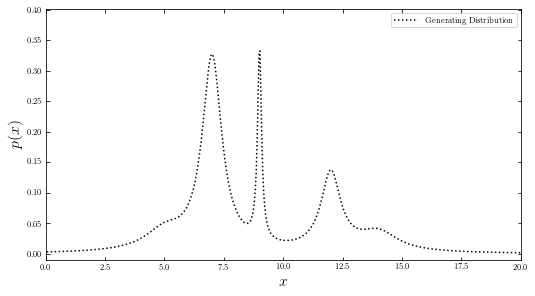

In [4]:
fig = plt.figure(figsize=(8, 4))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
ax = fig.add_subplot(111)
t = np.linspace(-10, 30, 1000)

# plot_generating_data(x_values) takes a row vector with x values as parameter 
# and plots the generating distribution of the given data using true_pdf() function.
def plot_generating_data(x_values):
    ax.plot(x_values, true_pdf(x_values), ':', color='black', zorder=3,
                label="Generating Distribution")
    # label the plot
    ax.set_ylabel('$p(x)$', fontsize=16)

    # set axis limit
    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plot_generating_data(t)
ax.legend(loc='upper right')
ax.set_xlabel('$x$', fontsize=16)

plt.show()

## Plot the results

### Kernel Density Estimation (KDE)

We often use Gaussian Kernel in KDE. Function $K(u)$ represents the weight at a given point, which is normalized such that $\int K(u)du = 1$.  
For a Gaussian Kernel:
$$K(u) = \frac{1}{ {2\pi}^{\frac{D}{2}} } e^{\frac{-{u}^2}{2}}$$

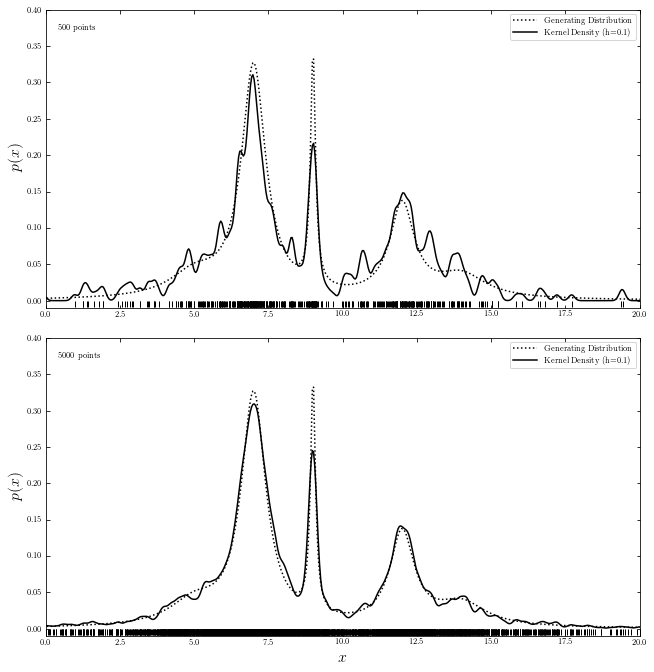

In [5]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
subplots = (211, 212)

# set N values to be 500 and 5000
N_values = (500, 5000)

# plot_kde(x_values) takes a row vector with x values as a parameter, computes the and plots KDE at x.
def plot_kde(x_values):
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))
    ax.plot(x_values, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density (h=0.1)")

    
for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    
    # plot generating data in comparison with KDE
    plot_generating_data(t)
    plot_kde(t)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    
    # make label and legend to the plot
    ax.legend(loc='upper right')
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

    if subplot == 212:
        ax.set_xlabel('$x$', fontsize=16)

plt.show()

### Nearest-Neighbor Density Estimation

The code below plots generating distribution and a result from nearest-neighbor estimation.

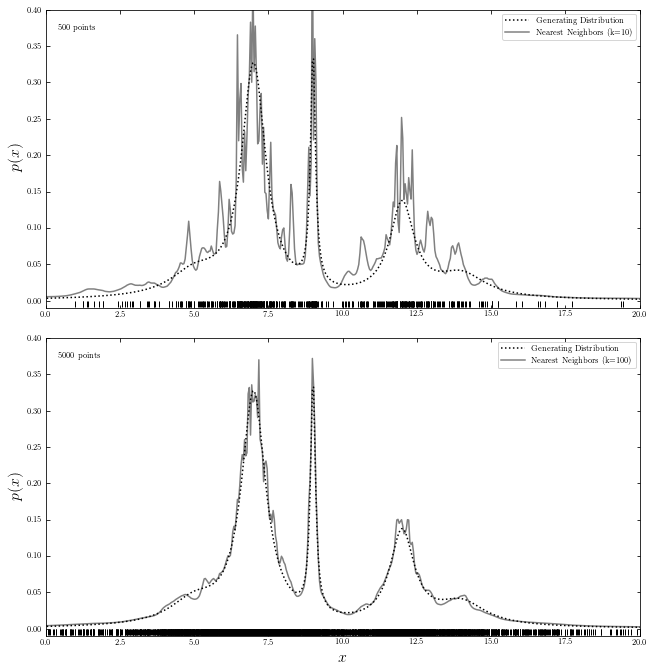

In [6]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

k_values = (10, 100)

# plot_nearest_neighor(x_values) takes a row vector with x values as a parameter
# computes the and plots density with Bayesian nearest neighbors at x.
def plot_nearest_neighbor(x_values):
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k).fit(xN[:, None])
    dens_nbrs = nbrs.eval(t[:, None]) / N
    ax.plot(x_values, dens_nbrs, '-', lw=1.5, color='gray', zorder=2,
            label="Nearest Neighbors (k=%i)" % k)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]

    # plot generating data in comparison with nearest neighbor
    plot_generating_data(t)
    plot_nearest_neighbor(t)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    
    # make label and legend to the plot
    ax.legend(loc='upper right')
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)

    if subplot == 212:
        ax.set_xlabel('$x$', fontsize=16)

plt.show()

### Bayesian Blocks

The code below plots generating distribution and Baysian block analysis.

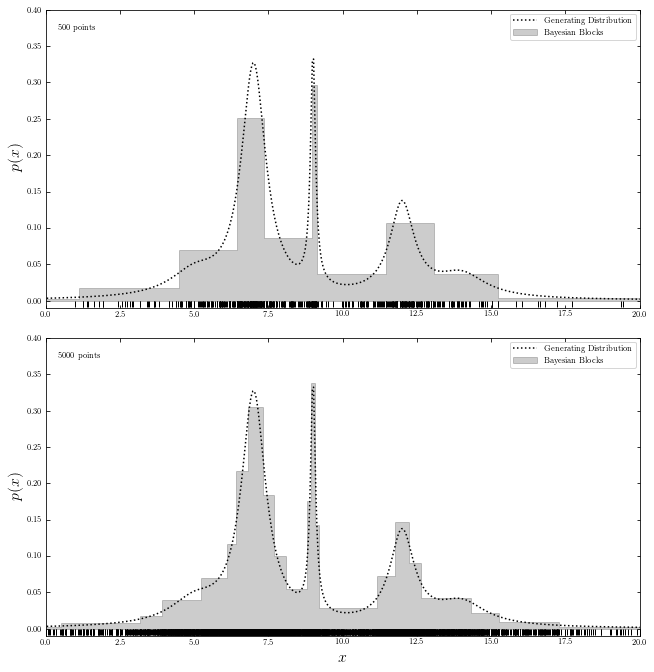

In [7]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

# plot_bayesian_block(x_values) takes a row vector with x values as a parameter
# computes the and plots the estimated Bayesian blocks using histogram.
def plot_bayesian_block(x_values):
    hist(x_values, bins='blocks', ax=ax, density=True, zorder=1,
         histtype='stepfilled', color='k', alpha=0.2,
         label="Bayesian Blocks")

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]

    # plot generating data in comparison with bayesian blocks
    plot_generating_data(t)
    plot_bayesian_block(xN)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')

    # make label and legend to the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$', fontsize=16)

plt.show()

### A comparison of the Three Estimations

The code below plots results from all three estimations in two subplots for reference.

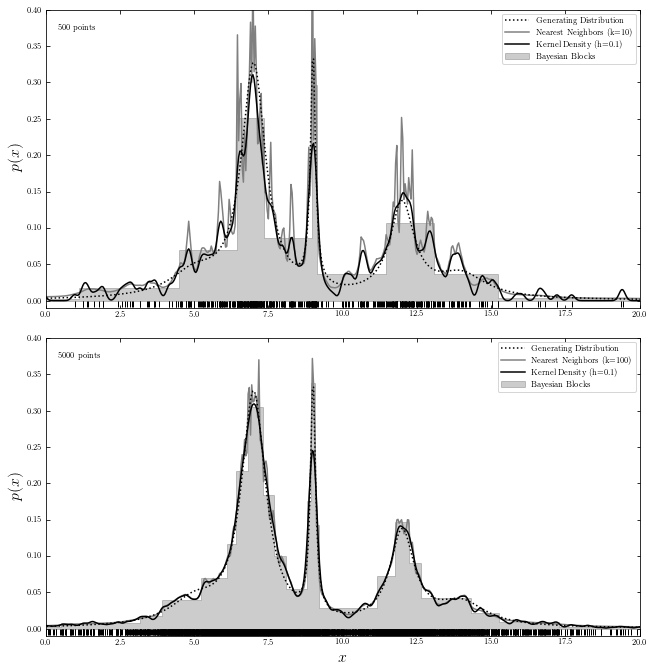

In [8]:
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]

    # plot the results from three methods and generating data
    plot_generating_data(t)
    plot_bayesian_block(xN)
    plot_nearest_neighbor(t)
    plot_kde(t)
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$', fontsize=16)

plt.show()

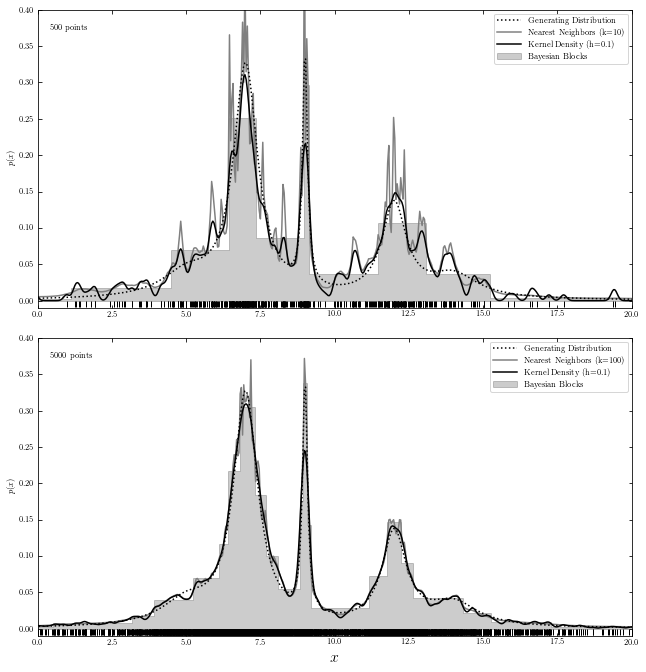

In [9]:
# same but without functions
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)
k_values = (10, 100)

for N, k, subplot in zip(N_values, k_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)
    
    # Compute density with KDE
    kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
    kde.fit(xN[:, None])
    dens_kde = np.exp(kde.score_samples(t[:, None]))

    # Compute density with Bayesian nearest neighbors
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k).fit(xN[:, None])
    dens_nbrs = nbrs.eval(t[:, None]) / N

    # plot the results
    ax.plot(t, true_pdf(t), ':', color='black', zorder=3,
            label="Generating Distribution")
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    hist(xN, bins='blocks', ax=ax, density=True, zorder=1,
         histtype='stepfilled', color='k', alpha=0.2,
         label="Bayesian Blocks")
    ax.plot(t, dens_nbrs, '-', lw=1.5, color='gray', zorder=2,
            label="Nearest Neighbors (k=%i)" % k)
    ax.plot(t, dens_kde, '-', color='black', zorder=3,
            label="Kernel Density (h=0.1)")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right')

    if subplot == 212:
        ax.set_xlabel('$x$', fontsize=16)

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

## Gaussian Mixture Models <a id='GMM'></a>
[Go to top](#toc)

## Introduction
**Gaussian mixture model** is a relatively simple and straightfoward numerical method on obtaining data likelihood function, and expectation maximization algorithm for maximizing the likelihood.  
The likelihood of a datum $x_i$ for a Gaussian mixture model is given by  

$$p(x_i|\theta) = \sum_{j=1}^{M} \alpha_{j}\mathcal{N}(\mu_j, \sigma_j)$$  

where vector of parameters $\theta$ is estimated from Gaussian with parameters $\mu_j$ and $\sigma_j$.   
$\alpha_j$ is the normalization factor for each Gaussian, with $\sum_{j=1}^{M} \alpha_{j} = 1$.   
M is given.
  
Both **Akaike information criterion (AIC)** and **Bayesian information criterion (BIC)** are scoring systems for model comparisons in classical statistics dealing with models with different numbers of free parameters.  

Specifically, **AIC** is computed as

$$AIC \equiv -2 ln(L^0(M)) + 2k + \frac{2k(k+1)}{N-k-1}$$  

**BIC** is computed as

$$BIC \equiv -2ln[L^0(M)] + k lnN$$  
  
In this notebook, we are going to apply Gaussian mixture model on a dataset of stellar metallicity. Then we will use AIC, and BIC for model comparisons, and then plot the best scored model in BIC.   

### 1. Import data and functions
The main function we use in this section is GaussianMixture from sklearn package. The data we use in the example is from a subset of SEGUE Stellar Parameters data, in which the parameters are estimated using (SEGUE Stellar Parameters Pipeline). Data reference from [Beers et al 2006](https://ui.adsabs.harvard.edu/abs/2006IAUJD..13E..26B/abstract).

### 2. Get the Segue Stellar Parameters Pipeline data

In [10]:
from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_sdss_sspp
from astroML.plotting.tools import draw_ellipse

In [11]:
data = fetch_sdss_sspp(cleaned=True)
X = np.vstack([data['FeH'], data['alphFe']]).T
# truncate dataset for speed
X = X[::5]

### 3. Compute Gaussian Mixture models & AIC/BIC
We calculate Gaussian Mixture model using compute_GaussianMixture, and take AIC/BIC from calculated models. 
We will evaluate between 1 and 13 Gaussian components of the model, and pick the number of components with the lowest BIC score.

In [12]:
N = np.arange(1, 14)

def compute_GaussianMixture(N, covariance_type='full', max_iter=1000):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GaussianMixture(n_components=N[i], max_iter=max_iter,
                                    covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GaussianMixture(N)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print("best fit converged:", gmm_best.converged_)
print("BIC: n_components =  %i" % N[i_best])

best fit converged: True
BIC: n_components =  5


### 4. Compute 2D density

In [13]:
FeH_bins = 51
alphFe_bins = 51
H, FeH_bins, alphFe_bins = np.histogram2d(data['FeH'], data['alphFe'],
                                          (FeH_bins, alphFe_bins))

Xgrid = np.array(list(map(np.ravel,
                          np.meshgrid(0.5 * (FeH_bins[:-1]
                                             + FeH_bins[1:]),
                                      0.5 * (alphFe_bins[:-1]
                                             + alphFe_bins[1:]))))).T
log_dens = gmm_best.score_samples(Xgrid).reshape((51, 51))

### 5. Plot true data density

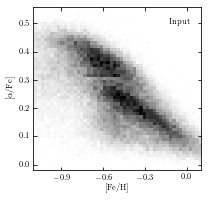

In [14]:
fig = plt.figure(figsize=(3, 3))

# define plot_figure to plot all figures with the same format.
def plot_figure(number, data, text):
    ax = fig.add_subplot(number)
    ax.imshow(data,
              origin='lower', interpolation='nearest', aspect='auto',
              extent=[FeH_bins[0], FeH_bins[-1],
                      alphFe_bins[0], alphFe_bins[-1]],
              cmap=plt.cm.binary)
    ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
    ax.set_xlabel(r'$\rm [Fe/H]$')
    ax.set_xlim(-1.101, 0.101)
    ax.text(0.93, 0.93, text,
            va='top', ha='right', transform=ax.transAxes)
    ax.set_ylim(alphFe_bins[0], alphFe_bins[-1])
    return ax

ax = plot_figure(111, H.T, "Input")
ax.set_ylabel(r'$\rm [\alpha/Fe]$')
plt.show()

### 6. Plot AIC/BIC
We pick the N value for smallest score in BIC for the following calculations.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

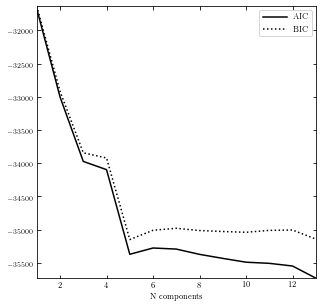

In [15]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

### 7. Best configurations for BIC
Taking N = 5 components as the result of BIC evaluation, we plot the best estimated model.   
The reconstructed density are in grayscale. The Gaussians are solid ellipses in the figure. 

Text(0, 0.5, '$\\rm [\\alpha/Fe]$')

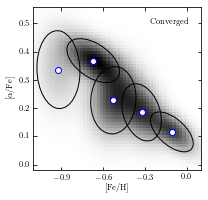

In [16]:
fig = plt.figure(figsize=(3,3))

ax = plot_figure(111, np.exp(log_dens), "Converged")

ax.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', ec='k')

ax.set_ylabel(r'$\rm [\alpha/Fe]$')

### 8. Compare input data and converged model
We plot the input true density distribution and best scored model from BIC in comparison. As a result, we find component number = 5 best discribes this metallicity dataset. 

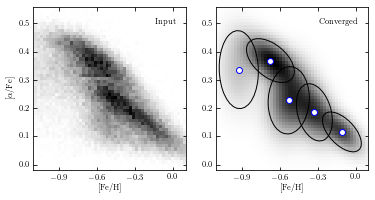

In [17]:
fig = plt.figure(figsize=(6, 3))

# plot density
ax1 = plot_figure(121, H.T, "Input")
ax1.set_ylabel(r'$\rm [\alpha/Fe]$')

ax2 = plot_figure(122, np.exp(log_dens), "Converged")
ax2.scatter(gmm_best.means_[:, 0], gmm_best.means_[:, 1], c='w')
for mu, C, w in zip(gmm_best.means_, gmm_best.covariances_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[1.5], ax=ax2, fc='none', ec='k')


## Extreme Deconvolution<a id='XD'></a>
[Go to top](#toc)

## Introduction
**Extreme deconvolution (XD)** combines Baysian extimation and Gaussian model in the algorithm to correct data with measurement errors.  
The algorithm basically assumes an observed value ${x_i}$, true value ${v_i}$, and noise ${\epsilon}$ 
have the following relationship:

$${x_i} = {R_i}{v_i}+{\epsilon_i}$$  

where ${R_i}$ is a projection matrix. After we compute this matrix using assumed Gaussian model, we are able to convert
noisy data back to true data.  
  
In section A, we plot four scattered point distribution graphs to show
how XD corrects noisy unsupervised data.  
("Unsupervised" here means no additional information is given on the data).  

In section B, we will apply real stellar data sample and see how XD works in correcting data distribution. Again we will plot four graphs in comparison.

## Import Data and Functions
The functions we need are in astroML. XDGMM is the main function we call to perform extreme deconvolution.  
The data we use to in this demostration is from the Stripe 82 Standard Star Catalog (high SNR) and single epoch observations (low SNR).  
More information about data used is in references.

In [18]:
import numpy as np
from matplotlib import pyplot as plt

from astroML.density_estimation import XDGMM
from astroML.plotting.tools import draw_ellipse

from astroML.crossmatch import crossmatch
from astroML.datasets import fetch_sdss_S82standards, fetch_imaging_sample
from astroML.stats import sigmaG


## A. XD on a generated dataset
In the first section, we will explore how XD works using randomly generated data set.

### 1. Generate true data
We first generate a distribution of "true data" using radomized numbers.
We will plot this data set as a reference to compare with the model derived from estimation with XD.  
Users can change sample size (N) to experiment the effectiveness of this method: Bigger sample size gives more information about the data set and is easier to converge, however it takes longer time to run in the method. The method may fail to converge due to small sample size.

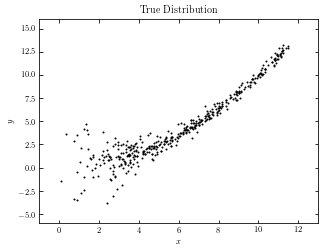

In [19]:
# Sample the dataset. 
# Here we use sample size = 400 in the example, 
# which converges in shorter time, and gives reasonable result.
N = 400
np.random.seed(0)

# generate the true data
x_true = (1.4 + 2 * np.random.random(N)) ** 2
y_true = 0.1 * x_true ** 2

# add scatter to "true" distribution
dx = 0.1 + 4. / x_true ** 2
dy = 0.1 + 10. / x_true ** 2

x_true += np.random.normal(0, dx, N)
y_true += np.random.normal(0, dy, N)

# define a function to plot all distributions in the same format
def plot_distribution(text, sample_x, sample_y):
    plt.figure(figsize=(5, 3.75))
    plt.scatter(sample_x, sample_y, s=4,lw=0,c='k')
    plt.xlim(-1, 13)
    plt.ylim(-6, 16)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(text,fontsize=10)

# plot true distribution
plot_distribution('True Distribution', x_true, y_true)

plt.show()

### 2. Generate noisy data
We add some radom noisy onto the true data to model what we may observe from true distribution.

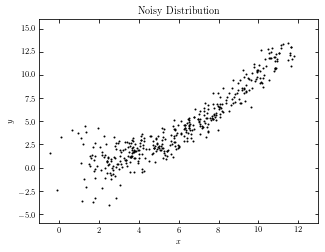

In [20]:
# add noise to get the "observed" distribution
dx = 0.2 + 0.5 * np.random.random(N)
dy = 0.2 + 0.5 * np.random.random(N)

x = x_true + np.random.normal(0, dx)
y = y_true + np.random.normal(0, dy)

# plot noisy distribution
plot_distribution('Noisy Distribution', x, y)

### 3. Compute extreme deconvolution (XD)
The code below computes the result.
In the XDGMM method, *n_components* (integer) defines the number of Gaussian components to fit to the data.  
*max_iter* (integer) defines number of EM iterations to perform (default as 100). Larger iteration number generally contributes better approximation to the true data, but takes longer time to execute.   
This cell is expected to execute in a bit long time around 1 minute.

In [21]:
# stack the results for computation
X = np.vstack([x, y]).T
Xerr = np.zeros(X.shape + X.shape[-1:])
diag = np.arange(X.shape[-1])
Xerr[:, diag, diag] = np.vstack([dx ** 2, dy ** 2]).T

clf = XDGMM(n_components=10, max_iter=200)

clf.fit(X, Xerr)
sample = clf.sample(N)

### 4. Plot the result from XD
We use scattered point to show the result of noisy data from XD correction. The plot shows a less scattered distribution 
than noisy data and even than true data, which better portraits a "underlying distribution."

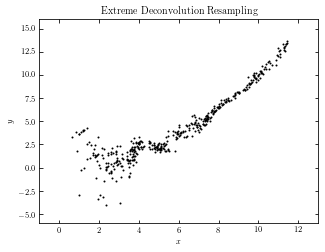

In [22]:
# plot noisy distribution
plot_distribution('Extreme Deconvolution Resampling', sample[:, 0], sample[:, 1])

### 5. Use subplots to show clear comparison
We plot true distribution (top left), noisy distribution (top right), and resampled distribution from XD (bottom left)
together to show a clear comparison for the effectiveness of this method in modeling.  
In addition, we add a clustered representation of the distribution (bottom right) to show the use in locating clusters with
XD method.

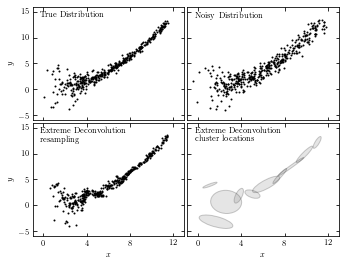

In [23]:
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

ax1 = fig.add_subplot(221)
ax1.scatter(x_true, y_true, s=4, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, s=4, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(sample[:, 0], sample[:, 1], s=4, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i], clf.V[i], scales=[2], ax=ax4,
                 ec='k', fc='gray', alpha=0.2)

titles = ["True Distribution", "Noisy Distribution",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]

ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-1, 13)
    ax[i].set_ylim(-6, 16)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(4))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$x$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$y$')

## B. XD on real star sample
In this section, we use a set of standard stars from S82 (high SNR), and a set of noisy single epoch of stars (low SNR). We will perform XD on the noisy data and see how it resamples the data into clusters.

### 1. Perform extinction correction on noisy sample
First, we fix the star's true color from dust extinction in noisy data sample. We apply extinction correction curve defined as 
$C_{\lambda} \equiv \frac{A_{\lambda}}{A}$, where the value of $C_{\lambda}$ for each band of S82 is from [Berry et al 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...757..166B/abstract).

In [24]:
# define u-g-r-i-z extinction from Berry et al, arXiv 1111.4985 multiply extinction by A_r
extinction_vector = np.array([1.810, 1.400, 1.0, 0.759, 0.561])

# Fetch and process the noisy imaging data
data_noisy = fetch_imaging_sample()

# select only stars
data_noisy = data_noisy[data_noisy['type'] == 6]

# Get the extinction-corrected magnitudes for each band
X = np.vstack([data_noisy[f + 'RawPSF'] for f in 'ugriz']).T
Xerr = np.vstack([data_noisy[f + 'psfErr'] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
X -= (extinction_vector * data_noisy['rExtSFD'][:, None])

### 2. Perform extinction correction on standard sample
Next, we stack the S82 star set and perform the same extinction correction on the data. 

In [25]:
# Fetch and process the stacked imaging data
data_stacked = fetch_sdss_S82standards()

# cut to RA, DEC range of imaging sample
RA = data_stacked['RA']
DEC = data_stacked['DEC']
data_stacked = data_stacked[(RA > 0) & (RA < 10) &
                            (DEC > -1) & (DEC < 1)]

# get stacked magnitudes for each band
Y = np.vstack([data_stacked['mmu_' + f] for f in 'ugriz']).T
Yerr = np.vstack([data_stacked['msig_' + f] for f in 'ugriz']).T

# extinction terms from Berry et al, arXiv 1111.4985
Y -= (extinction_vector * data_stacked['A_r'][:, None])

# quality cuts
g = Y[:, 1]
mask = ((Yerr.max(1) < 0.05) &
        (g < 20))
data_stacked = data_stacked[mask]
Y = Y[mask]
Yerr = Yerr[mask]

### 3. Cross-match two data sets
We use cross-match to match the noisy sample to standard sample, and make two sets comparable.

In [26]:
Xlocs = np.hstack((data_noisy['ra'][:, np.newaxis],
                   data_noisy['dec'][:, np.newaxis]))
Ylocs = np.hstack((data_stacked['RA'][:, np.newaxis],
                   data_stacked['DEC'][:, np.newaxis]))

print("number of noisy points:  ", Xlocs.shape)
print("number of stacked points:", Ylocs.shape)

# find all points within 0.9 arcsec.  This cutoff was selected
# by plotting a histogram of the log(distances).
dist, ind = crossmatch(Xlocs, Ylocs, max_distance=0.9 / 3600)

noisy_mask = (~np.isinf(dist))
stacked_mask = ind[noisy_mask]

# select the data
data_noisy = data_noisy[noisy_mask]
X = X[noisy_mask]
Xerr = Xerr[noisy_mask]

data_stacked = data_stacked[stacked_mask]
Y = Y[stacked_mask]
Yerr = Yerr[stacked_mask]

# double-check that our cross-match succeeded
assert X.shape == Y.shape
print("size after crossmatch:", X.shape)

number of noisy points:   (82003, 2)
number of stacked points: (13377, 2)
size after crossmatch: (12313, 5)


### 4. Define W matrix and calculate covariance

In [27]:
# first define mixing matrix W
W = np.array([[0, 1, 0, 0, 0],    # g magnitude
              [1, -1, 0, 0, 0],   # u-g color
              [0, 1, -1, 0, 0],   # g-r color
              [0, 0, 1, -1, 0],   # r-i color
              [0, 0, 0, 1, -1]])  # i-z color

X = np.dot(X, W.T)
Y = np.dot(Y, W.T)

# compute error covariance from mixing matrix
Xcov = np.zeros(Xerr.shape + Xerr.shape[-1:])
Xcov[:, range(Xerr.shape[1]), range(Xerr.shape[1])] = Xerr ** 2

# each covariance C = WCW^T
# best way to do this is with a tensor dot-product
Xcov = np.tensordot(np.dot(Xcov, W.T), W, (-2, -1))

### 5. Plot two raw data sets
We choose ten percent of the points in each data sets to plot in comparison. As we can see from the result, before XD, the sigle epoch (right) has more noise than standard stars (left).

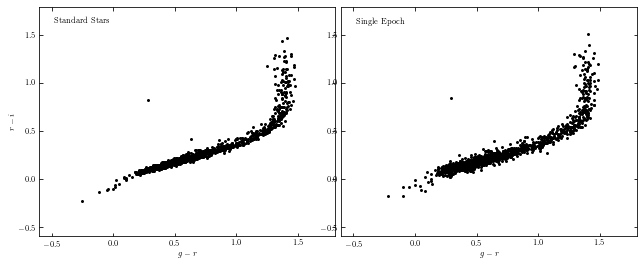

In [28]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(10, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(121)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')
ax1.set_ylabel('$r-i$')

ax2 = fig.add_subplot(122)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

titles = ["Standard Stars", "Single Epoch"]
ax = [ax1, ax2]

for i in range(2):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    ax[i].set_xlabel('$g-r$')

### 6. Calculate XD value
We define compute_XD and save the result to pickle file. This cell is estimated to take a long running time (more than 20 minutes).

In [29]:
def compute_XD(n_clusters=12, rseed=0, max_iter=100, verbose=True):
    np.random.seed(rseed)
    clf = XDGMM(n_clusters, max_iter=max_iter, tol=1E-5, verbose=verbose)
    clf.fit(X, Xcov)
    return clf

clf = compute_XD(12)

1: log(L) = 32868
    (1e+02 sec)
2: log(L) = 33422
    (1.2e+02 sec)
3: log(L) = 33742
    (1.1e+02 sec)
4: log(L) = 33967
    (1e+02 sec)
5: log(L) = 34155
    (96 sec)
6: log(L) = 34307
    (1.1e+02 sec)
7: log(L) = 34418
    (71 sec)
8: log(L) = 34507
    (77 sec)
9: log(L) = 34583
    (3e+02 sec)
10: log(L) = 34648
    (1.7e+02 sec)
11: log(L) = 34707
    (85 sec)
12: log(L) = 34762
    (87 sec)
13: log(L) = 34818
    (73 sec)
14: log(L) = 34884
    (48 sec)
15: log(L) = 34943
    (34 sec)
16: log(L) = 34988
    (27 sec)
17: log(L) = 35028
    (25 sec)
18: log(L) = 35066
    (24 sec)
19: log(L) = 35103
    (24 sec)
20: log(L) = 35138
    (24 sec)
21: log(L) = 35174
    (24 sec)
22: log(L) = 35208
    (23 sec)
23: log(L) = 35242
    (24 sec)
24: log(L) = 35276
    (23 sec)
25: log(L) = 35310
    (22 sec)
26: log(L) = 35342
    (22 sec)
27: log(L) = 35375
    (21 sec)
28: log(L) = 35406
    (23 sec)
29: log(L) = 35436
    (24 sec)
30: log(L) = 35465
    (23 sec)
31: log(L) = 35493
 

### 7. Plot results in comparison
Here we plot the result of noisy data after XD in scattered points (lower left), with a cluster location estimation in ellipses, in comparison with the original two data sets.  
After XD resampling, the resampled data distributes less scattered than the original noisy data. It also shows a better clustered pattern than the standard star distribution.

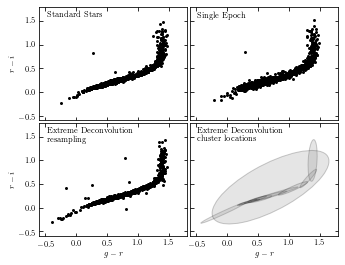

In [30]:
# Fit and sample from the underlying distribution
np.random.seed(42)
X_sample = clf.sample(X.shape[0])

# plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.12, right=0.95,
                    bottom=0.1, top=0.95,
                    wspace=0.02, hspace=0.02)

# only plot 1/10 of the stars for clarity
ax1 = fig.add_subplot(221)
ax1.scatter(Y[::10, 2], Y[::10, 3], s=9, lw=0, c='k')

ax2 = fig.add_subplot(222)
ax2.scatter(X[::10, 2], X[::10, 3], s=9, lw=0, c='k')

ax3 = fig.add_subplot(223)
ax3.scatter(X_sample[::10, 2], X_sample[::10, 3], s=9, lw=0, c='k')

ax4 = fig.add_subplot(224)
for i in range(clf.n_components):
    draw_ellipse(clf.mu[i, 2:4], clf.V[i, 2:4, 2:4], scales=[2],
                 ec='k', fc='gray', alpha=0.2, ax=ax4)

titles = ["Standard Stars", "Single Epoch",
          "Extreme Deconvolution\n  resampling",
          "Extreme Deconvolution\n  cluster locations"]
ax = [ax1, ax2, ax3, ax4]

for i in range(4):
    ax[i].set_xlim(-0.6, 1.8)
    ax[i].set_ylim(-0.6, 1.8)

    ax[i].xaxis.set_major_locator(plt.MultipleLocator(0.5))
    ax[i].yaxis.set_major_locator(plt.MultipleLocator(0.5))

    ax[i].text(0.05, 0.95, titles[i],
               ha='left', va='top', transform=ax[i].transAxes)

    if i in (0, 1):
        ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_xlabel('$g-r$')

    if i in (1, 3):
        ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax[i].set_ylabel('$r-i$')

### 8. Plot width of Locus
We plot the widths of standard stars, single epoch and XD resampled result in one graph.   
On the x-axis shows the width of locus, also called w color, defined as 
$w = -0.227g + 0.792r - 0.567i + 0.05$.  
$\sigma_{G}$ of the Gaussian distribution fit is the smallest in XD resampled result. This shows the effectiveness of correcting and clustering noisy data.

Text(0, 0.5, '$N(w)$')

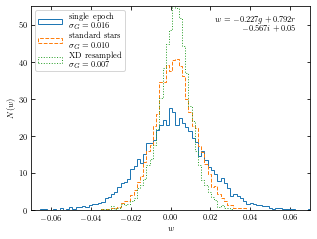

In [31]:
# Second figure: the width of the locus
fig = plt.figure(figsize=(5, 3.75))
ax = fig.add_subplot(111)

labels = ['single epoch', 'standard stars', 'XD resampled']
linestyles = ['solid', 'dashed', 'dotted']
for data, label, ls in zip((X, Y, X_sample), labels, linestyles):
    g = data[:, 0]
    gr = data[:, 2]
    ri = data[:, 3]

    r = g - gr
    i = r - ri

    mask = (gr > 0.3) & (gr < 1.0)
    g = g[mask]
    r = r[mask]
    i = i[mask]

    w = -0.227 * g + 0.792 * r - 0.567 * i + 0.05

    sigma = sigmaG(w)

    ax.hist(w, bins=np.linspace(-0.08, 0.08, 100), linestyle=ls,
            histtype='step', label=label + '\n\t' + r'$\sigma_G=%.3f$' % sigma,
            density=True)

ax.legend(loc=2)
ax.text(0.95, 0.95, '$w = -0.227g + 0.792r$\n$ - 0.567i + 0.05$',
        transform=ax.transAxes, ha='right', va='top')

ax.set_xlim(-0.07, 0.07)
ax.set_ylim(0, 55)

ax.set_xlabel('$w$')
ax.set_ylabel('$N(w)$')


## Bonus: Density Estimation for the SDSS "Great Wall"<a id='SDSS'></a>
[Go to top](#toc)

## Introduction
Here, we are going to estimate density of galaxies in the SDSS "Great Wall" using different methods.  
Raw data are often displayed in a way like scattered point or sorted with different sized bins in histogram. However, it hard to see a smooth distribution pattern in dots and histogram bins. Therefore, we need estimators for mining the underlying distribution pattern.   


Firstly, we will apply **Kernal Density Estimation (KDE)** with different kernels (Gaussian, top-hat, and exponential kernels).
For a set of measurements ${x_i}$, the KDE at x is 

$$\hat{f_{N}}(x) = \frac{1}{Nh^D} \sum_{i=1}^{N} K(\frac{d(x,x_i)}{h})$$  

where D is the dimensions of the parameter space.


Secondly, we will use **K-Nearest-Neighbor Estimation** with different structure scales (different K values). The estimated function is calculated as

$$\hat{f_K}(x) = \frac{K}{V_D(d_K)}$$  
  
Lastly, we will use **Gaussian Mixture Model (GMM)** on the same dataset. The density function of points is given by

$$\rho(x) = Np(x) = N \sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$$

## Import Data and Methods
The sample data used in this notebook is the a galaxy sample contains 8014 galaxies centered in the SDSS "Great Wall". Data reference from [Gott III et al 2005](https://arxiv.org/abs/astro-ph/0310571).  
The main methods used here are KernalDensity, KNeighborsDensity, and GaussianMixture.

In [32]:
from sklearn.neighbors import KernelDensity
from astroML.density_estimation import KNeighborsDensity
from sklearn.mixture import GaussianMixture
from astroML.datasets import fetch_great_wall

## Create Grids and Define Figure Format

In [39]:
# Create the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                            np.linspace(ymin, ymax, Ny)))).T

# adjust figure into the same size
def adjust_figure(x, y):
    fig = plt.figure(figsize=(x, y))
    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                    hspace=0.01, wspace=0.01)

# define plot_figure to plot all KDE figures with the same format.
def plot_figure(number, data, text):
    ax = plt.subplot(number, aspect='equal')
    ax.imshow(data, origin='lower', norm=matplotlib.colors.LogNorm(),
               extent=(ymin, ymax, xmin, xmax), cmap=plt.cm.binary)
    ax.text(0.95, 0.9, text, ha='right', va='top',
             transform=ax.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))
    ax.set_xlim(ymin, ymax - 0.01)
    ax.set_ylim(xmin, xmax)
    #ax.images[0].set_clim(0.01, 0.8)
    return ax

## Show Input Data in Scattered Points
The plot projects galaxies in SDSS "Great Wall" as scatted points by their spatial locations onto the equatorial plane (declination ~ 0$^{\circ}$). The graph below shows the location of each point, but it is hard to get "clustered information" from. 

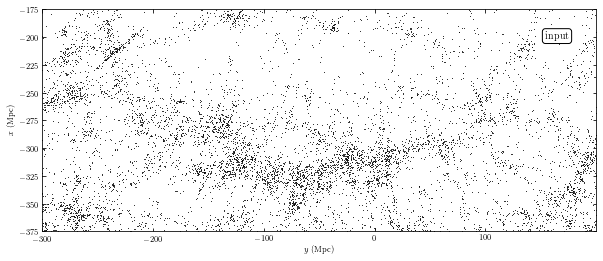

In [41]:
# Fetch the great wall data
X = fetch_great_wall()

adjust_figure(10,4.4)

# First plot: scatter the points
ax1 = plt.subplot(111, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))

ax1.set_xlim(ymin, ymax - 0.01)
ax1.set_ylim(xmin, xmax)
    
ax1.set_xlabel('$y$ (Mpc)')
ax1.set_ylabel('$x$ (Mpc)')

plt.show()

## Evaluate KDE with Gaussian Kernel
Use a *Gaussian kernel* to evaluate the kernel density. The function $K(u)$, a smooth function, represents the weight at a given point, which is normalized such that $\int K(u)du = 1$.  
The expression for Gaussian kernel is 

$$K(u) = \frac{1}{ {2\pi}^{\frac{D}{2}} } e^{\frac{-{u}^2}{2}}$$  

where D is the number of dimensions of the parameter space and $u = d(x, x_i) /h$.

Text(0, 0.5, '$x$ (Mpc)')

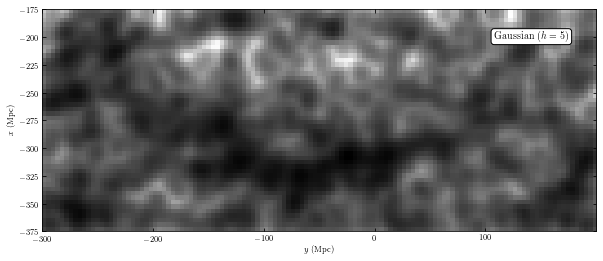

In [45]:
# evaluate Gaussian kernel
def estimate_kde(ker, bandwidth=5):
    kde = KernelDensity(bandwidth, kernel=ker)
    log_dens = kde.fit(X).score_samples(Xgrid)
    dens = X.shape[0] * np.exp(log_dens).reshape((Ny, Nx))
    return dens
   
dens1 = estimate_kde('gaussian')

adjust_figure(10,4.4)
ax = plot_figure(111, dens1.T, "Gaussian $(h=5)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

## Evaluate KDE with Exponential Kernel
Use a *exponential kernel* to evaluate the kernel density. The expression for exponential kernel is 

$$K(u) = \frac{1}{D!V_{D}(1)}e^{-|u|}.$$  

where $V_D(r)$ is the volume of a D-dimensional hypersphere of radius r.  
This kernel gives the "sharpest" estimation for each distribution feature.  

Text(0, 0.5, '$x$ (Mpc)')

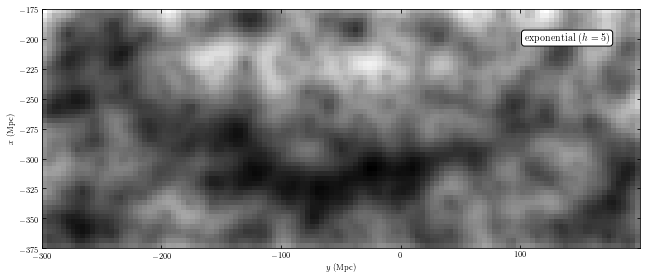

In [46]:
# Fourth plot: exponential kernel
dens3 = estimate_kde('exponential')

adjust_figure(10,5.5)
ax = plot_figure(111, dens3.T, "exponential $(h=5)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

## Evaluate density using K-Nearest-Neighbor Estimation
Another estimator is the K-nearest-neighbor estimator, originally proposed by [Dressler et al. 1980](https://ui.adsabs.harvard.edu/abs/1980ApJ...236..351D/abstract) . In this method, the implied point density at an arbitrary position x is estimated as

$$\hat{f_K}(x) = \frac{K}{V_D(d_K)}$$

where $V_D$ is evaluated volume, and D is the problem dimensionality.  
  
By taking the assumption that the underlying density field is locally constant, we can further simplify this method as

$$\hat{f_K}(x) = \frac{C}{d_K^D}$$

where C is a scaling factor evaluated by requiring that the sum of the product of $\hat{f_K}(x)$ and
pixel volume is equal to the total number of data points.

In this method, we can change parameter k to get different estimation result.
K should be at least 5 because the estimator is biased and has a large variance for smaller K; see [Casertano, S. and Hut, P.](https://ui.adsabs.harvard.edu/abs/1985ApJ...298...80C/abstract)

Text(0, 0.5, '$x$ (Mpc)')

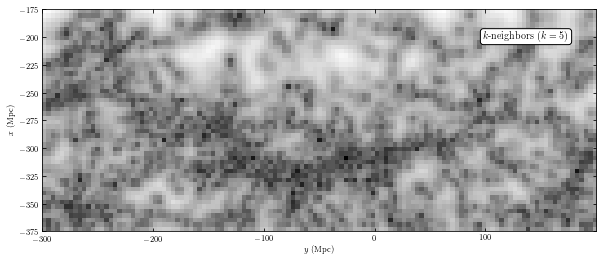

In [47]:
# calculate K Neighbors Density with k = 5
knn5 = KNeighborsDensity('bayesian', 5)
dens_k5 = knn5.fit(X).eval(Xgrid).reshape((Ny, Nx))

# plot K Neighbor with k = 5
adjust_figure(10,4.4)
ax = plot_figure(111, dens_k5.T, "$k$-neighbors $(k=5)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

The fractional accuracy increases with K at the expense of the spatial resolution. Taking k = 40 instead of k = 5, we see different estimation result.

Text(0, 0.5, '$x$ (Mpc)')

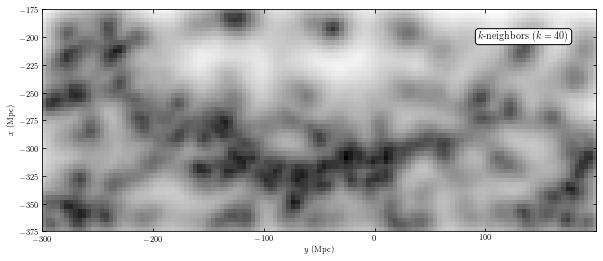

In [48]:
# calculate K Neighbors Density with k = 40
knn40 = KNeighborsDensity('bayesian', 40)
dens_k40 = knn40.fit(X).eval(Xgrid).reshape((Ny, Nx))

# plot K Neighbor with k = 40
adjust_figure(10,4.4)
ax = plot_figure(111, dens_k40.T, "$k$-neighbors $(k=40)$")

ax.set_xlabel('$y$ (Mpc)')
ax.set_ylabel('$x$ (Mpc)')

## Compare Estimated Results

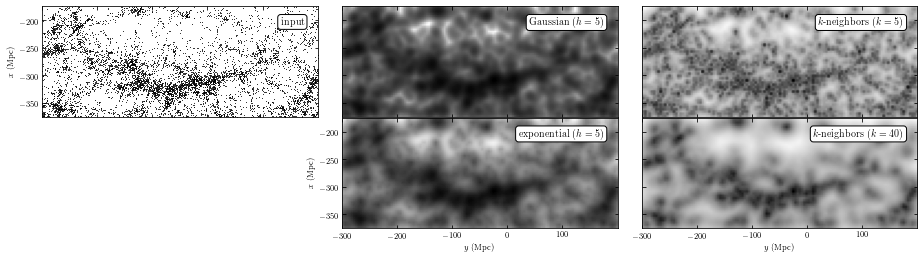

In [52]:
adjust_figure(15,4.4)

# First plot: scatter the points
ax1 = plt.subplot(231, aspect='equal')
ax1.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')
ax1.text(0.95, 0.9, "input", ha='right', va='top',
         transform=ax1.transAxes,
         bbox=dict(boxstyle='round', ec='k', fc='w'))
ax1.set_xlim(ymin, ymax - 0.01)
ax1.set_ylim(xmin, xmax)

# Second plot: gaussian kernel
ax2 = plot_figure(232, dens1.T, "Gaussian $(h=5)$")

# Third plot: K nearest neighbor with k=5
ax3 = plot_figure(233, dens_k5.T, "$k$-neighbors $(k=5)$")

# Fourth plot: exponential kernel
ax4 = plot_figure(235, dens3.T, "exponential $(h=5)$")

# fifth plot: K nearest neighbor with k=40
ax5 = plot_figure(236, dens_k40.T, "$k$-neighbors $(k=40)$")

for ax in [ax1, ax2, ax3]:
    ax.xaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax4, ax5]:
    ax.set_xlabel('$y$ (Mpc)')

for ax in [ax2, ax3, ax5]:
    ax.yaxis.set_major_formatter(plt.NullFormatter())

for ax in [ax1, ax4]:
    ax.set_ylabel('$x$ (Mpc)')

plt.show()

## Use Gaussian Mixture Model
GMM calculate the underlying pdf of a point as a sum of multi-dimensional Gaussians using the equation below

$$\rho(x) = Np(x) = N \sum_{j=1}^{M} \alpha_j \mathcal{N}(\mu_j, \Sigma_j)$$

where M is the number of Gaussians, $\mu_j$ is the the location, and $\Sigma_j$ is the covariance of a Gaussian.

converged: True


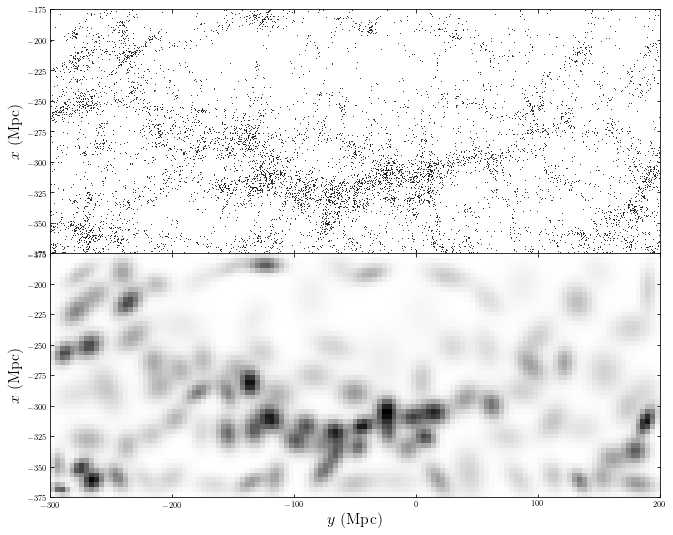

In [53]:
# Calculate GMM
def compute_GMM(n_clusters, max_iter=1000, tol=3, covariance_type='full'):
    clf = GaussianMixture(n_clusters, covariance_type=covariance_type,
                          max_iter=max_iter, tol=tol, random_state=0)
    clf.fit(X)
    print("converged:", clf.converged_)
    return clf

clf = compute_GMM(n_clusters=100)
log_dens = clf.score_samples(Xgrid).reshape(Ny, Nx)

# plot figures
fig = plt.figure(figsize=(10, 8.8))
fig.subplots_adjust(hspace=0, left=0.08, right=0.95, bottom=0.13, top=0.9)

ax = fig.add_subplot(211, aspect='equal')
ax.scatter(X[:, 1], X[:, 0], s=1, lw=0, c='k')

ax.set_xlim(ymin, ymax - 0.01)
ax.set_ylim(xmin, xmax)

ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.ylabel(r'$x\ {\rm (Mpc)}$', fontsize=16)

ax = fig.add_subplot(212, aspect='equal')
ax.imshow(np.exp(log_dens.T), origin='lower', cmap=plt.cm.binary,
          extent=[ymin, ymax, xmin, xmax])
ax.set_xlabel(r'$y\ {\rm (Mpc)}$', fontsize=16)
ax.set_ylabel(r'$x\ {\rm (Mpc)}$', fontsize=16)

plt.show()